In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import json

In [2]:
df = pd.read_csv("data/og_train.csv")
df.secondary_type = df.secondary_type.fillna("None")
df.head()

,image_id,main_type,secondary_type
0,aae8b80f-e334-4974-a3c6-5e922fb76284,Bug,Grass
1,cd792a8c-717b-4a60-85ee-7940ce0f81bb,Water,None
2,b2206a6a-d898-4c01-9b0f-6775a2b302a8,Electric,None
3,6f6d6294-93da-410a-801a-29dbe353b148,Fairy,None
4,7ae5d5d4-650b-40c9-bebb-7153f45f793c,Electric,Fairy


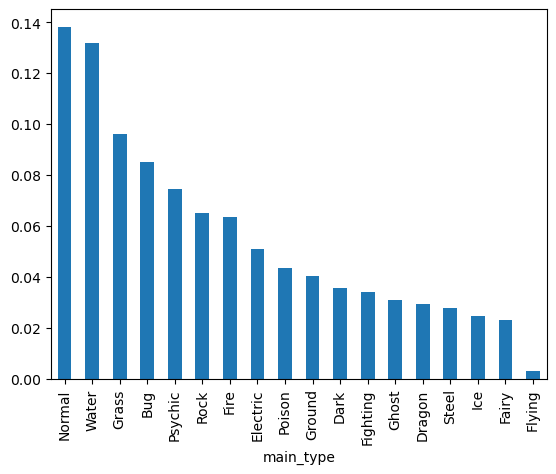

In [3]:
df.value_counts("main_type", normalize=True).plot.bar()
plt.show()

In [4]:
val_index = df.sample(frac=0.2, random_state=0).index 
val_split = df.loc[val_index]
train_split = df.loc[[i for i in df.index if i not in val_index]]
df["ds_type"] = None
df.loc[val_split.index, "ds_type"] = "val"
df.loc[train_split.index, "ds_type"] = "train"
df["path"] = "data/train/" + df.image_id + ".png"

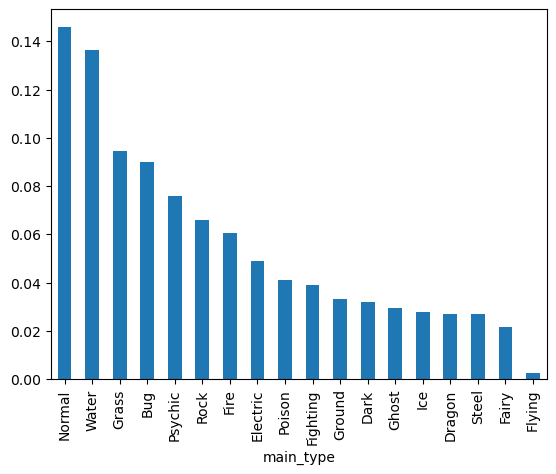

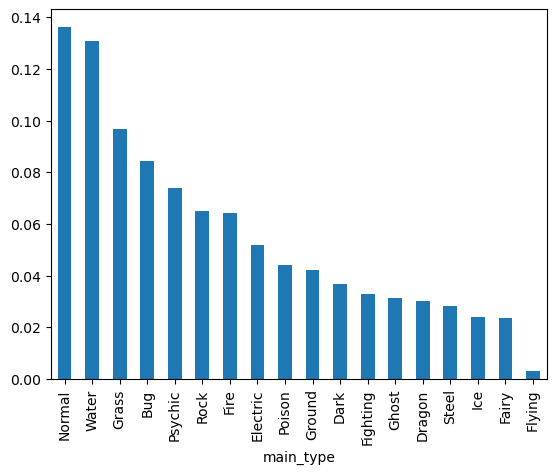

In [5]:

val_split.value_counts("main_type", normalize=True).plot.bar()
plt.show()
train_split.value_counts("main_type", normalize=True).plot.bar()
plt.show()

In [6]:
df.ds_type.value_counts(normalize=True)

ds_type
train    0.8
val      0.2
Name: proportion, dtype: float64

In [7]:
test_images = pd.DataFrame({"path": glob("data/test/*.png")})
test_images["ds_type"] = "test"
test_images["image_id"] = test_images.path.apply(lambda x: os.path.basename(x).replace(".png",""))

df = pd.concat((df, test_images))

In [8]:
add_data = pd.read_csv("data/generated_imgs.csv", index_col=0)
add_data  = add_data.rename(columns = {
    "primary":"main_type",
    "Id": "image_id",
})[["image_id","main_type", "background_path"]]

add_data["path"] = "data/generated/" + add_data.image_id.astype(str) + ".jpg"

labels = set(add_data.main_type.unique())
og = set(df.main_type)
og.discard(np.nan)
assert labels == og

df = pd.concat((df, add_data))
df.index = np.arange(len(df))

paths = df.background_path.unique()
paths = paths[~pd.isnull(paths)]
val_paths = set(paths[:int(len(paths)*0.2)])

val_aug = df.query("background_path in @val_paths").index
df.loc[val_aug, "ds_type"] = "aug_val"

train_aug = df.query("background_path  not in @val_paths and background_path.notna()").index
df.loc[train_aug, "ds_type"] = "aug_train"

In [9]:
def crop_path(path:str):
    
    base, ending = os.path.split(path)
    
    return os.path.join(base + "_cropped", ending)

df["cropped_path"] = df.path.apply(crop_path)
df["cropp_exists"] = df.cropped_path.apply(os.path.exists)
df.groupby("ds_type").cropp_exists.mean()

ds_type
aug_train    0.964392
aug_val      0.970967
test         0.960606
train        0.951087
val          0.947205
Name: cropp_exists, dtype: float64

In [10]:
classes = sorted(df.main_type.dropna().unique())

class2id = {b:a for a,b in enumerate(classes)}
id2class = {a:b for a,b in enumerate(classes)}

with open("data/class2id.json", "w") as f:
    json.dump(class2id, f)
    
with open("data/id2class.json", "w") as f:
    json.dump(id2class, f)

class2id[np.nan] = None


df["class_id"] = df.main_type.map(class2id)
to_counts = df.class_id.value_counts().to_dict()
df["class_counts"] = df.class_id.map(to_counts)
df.class_counts


0        1696.0
1        1975.0
2        1457.0
3        1294.0
4        1457.0
          ...  
28085    1335.0
28086    1265.0
28087    1457.0
28088    1383.0
28089    1457.0
Name: class_counts, Length: 28090, dtype: float64

In [11]:
df.to_csv("data/info.csv")